In [1]:
#import modules and set up inline plotting
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#create helper functions
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

def run_command (c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");
    '''
    return run_query(q)
    
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [3]:
q = '''
   WITH invoice_genre_sales AS
    (
    SELECT
     invoice_id,
     g.name genre,
     sum(il.unit_price * il.quantity) sales
    FROM invoice_line il 
    JOIN track t 
    ON il.track_id = t.track_id
    JOIN genre g on t.genre_id = g.genre_id
    GROUP BY 1,2),
    
    usa_invoice AS 
    (SELECT
    invoice_id
    FROM invoice i JOIN customer c ON i.customer_id = c.customer_id
    WHERE c.country = "USA")
    
    SELECT 
        genre,
        SUM(sales) total_sales
    FROM usa_invoice ui 
    JOIN invoice_genre_sales igt
    ON ui.invoice_id = igt.invoice_id
    GROUP BY genre
    ORDER BY total_sales DESC'''

run_query(q)

,genre,total_sales
0,Rock,555.39
1,Alternative & Punk,128.70
2,Metal,122.76
3,R&B/Soul,52.47
4,Blues,35.64
5,Alternative,34.65
6,Pop,21.78
7,Latin,21.78
8,Hip Hop/Rap,19.80
9,Jazz,13.86


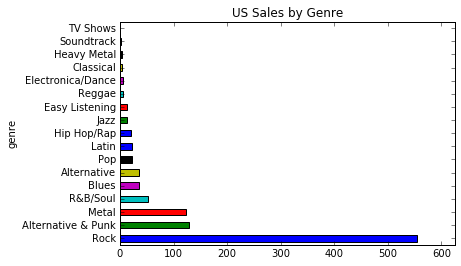

In [4]:
us_genre_sales = run_query(q)
us_genre_sales.set_index("genre",inplace = True,drop=True)
us_genre_sales['total_sales'].plot.barh(
    title = "US Sales by Genre",
    xlim = (0,625))

We should go with Red Tone, Metior and the Girls, and Slim Jim Blues.

I recommend closely monitoring the sales of Meteor and the Girls.  Both Pop and similar genres sell poorly at this store relative to Rock and related genres.

Blues sells fairly well, as do the related genres R&B/Soul, Metal, and Rock.

The store doesn't maintain a separate Punk genre, but it seems likely that Punk will sell well based on the sales of related genres such as Rock and Metal, as well as the existence of an Alternative genre separate from the mixed Alternative & Punk genre.

In [5]:
sales_by_rep_q = '''
   WITH invoice_genre_sales AS
    (
    SELECT
     invoice_id,
     customer_id,
     g.name genre,
     sum(il.unit_price * il.quantity) sales
    FROM invoice_line il 
        JOIN track t 
        ON il.track_id = t.track_id
            JOIN genre g 
            ON t.genre_id = g.genre_id
    GROUP BY 1,2,3),
    
    employee_customer AS
    (
    SELECT 
    e.first_name || " "||e.last_name sales_rep,
    e.reports_to,
    e.title,
    e.country,
    e.city,
    e.state,
    c.customer_id
    FROM employee e
        JOIN customer c 
        ON e.employee_id = c.support_rep_id)
        

    SELECT 
    ec.sales_rep,
    sum(i.total) sales 
    FROM employee_customer ec 
        JOIN invoice i
        ON i.customer_id = ec.customer_id
    GROUP BY 1
    ORDER BY 2 DESC
    '''
run_query(sales_by_rep_q)

,sales_rep,sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


In [6]:
check_employees = '''SELECT * FROM employee'''
run_query(check_employees)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
3,4,Park,Margaret,Sales Support Agent,2.0,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
4,5,Johnson,Steve,Sales Support Agent,2.0,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com
5,6,Mitchell,Michael,IT Manager,1.0,1973-07-01 00:00:00,2016-10-17 00:00:00,5827 Bowness Road NW,Calgary,AB,Canada,T3B 0C5,+1 (403) 246-9887,+1 (403) 246-9899,michael@chinookcorp.com
6,7,King,Robert,IT Staff,6.0,1970-05-29 00:00:00,2017-01-02 00:00:00,590 Columbia Boulevard West,Lethbridge,AB,Canada,T1K 5N8,+1 (403) 456-9986,+1 (403) 456-8485,robert@chinookcorp.com
7,8,Callahan,Laura,IT Staff,6.0,1968-01-09 00:00:00,2017-03-04 00:00:00,923 7 ST NW,Lethbridge,AB,Canada,T1H 1Y8,+1 (403) 467-3351,+1 (403) 467-8772,laura@chinookcorp.com


In [7]:
rep_genre_sales_q = '''
   WITH invoice_genre_sales AS
    (
    SELECT
     il.invoice_id,
     i.customer_id,
     g.name genre,
     sum(il.unit_price * il.quantity) sales
    FROM invoice_line il 
        JOIN track t 
        ON il.track_id = t.track_id
            JOIN genre g 
            ON t.genre_id = g.genre_id
                JOIN invoice i 
                ON il.invoice_id = i.invoice_id
    GROUP BY 1,2,3),
    
    employee_customer AS
    (
    SELECT 
    e.first_name || " "||e.last_name sales_rep,
    c.customer_id
    FROM employee e
        JOIN customer c 
        ON e.employee_id = c.support_rep_id),
        
   rep_sales AS
   (
   SELECT 
    ec.sales_rep,
    sum(i.total) sales 
    FROM employee_customer ec 
        JOIN invoice i
        ON i.customer_id = ec.customer_id
    GROUP BY 1
    )
        
    SELECT
    ec.sales_rep,
    igs.genre,
    sum(igs.sales) genre_sales,
    sum(igs.sales)/rs.sales genre_share
    FROM employee_customer ec
        JOIN invoice_genre_sales igs
        ON ec.customer_id = igs.customer_id
            JOIN  rep_sales rs 
            ON rs.sales_rep = ec.sales_rep
    
    GROUP BY 1,2
    HAVING genre_share > .05
    ORDER BY 1,3
   
    '''
run_query(rep_genre_sales_q)

,sales_rep,genre,genre_sales,genre_share
0,Jane Peacock,Alternative & Punk,152.46,0.088050
1,Jane Peacock,Metal,231.66,0.133791
2,Jane Peacock,Rock,1035.54,0.598056
3,Margaret Park,Alternative & Punk,167.31,0.105625
4,Margaret Park,Metal,222.75,0.140625
5,Margaret Park,Rock,777.15,0.490625
6,Steve Johnson,Metal,158.40,0.113636
7,Steve Johnson,Alternative & Punk,167.31,0.120028
8,Steve Johnson,Rock,795.96,0.571023


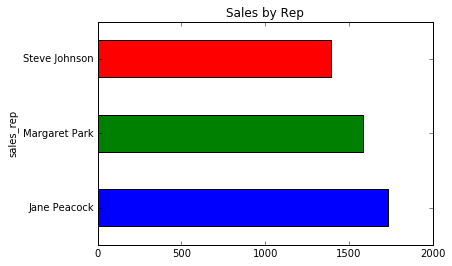

In [8]:
sales_by_rep = run_query(sales_by_rep_q)
type(sales_by_rep['sales_rep'])
sales_by_rep.set_index("sales_rep",inplace = True, drop=True)
sales_by_rep['sales'].plot.barh(
    title = "Sales by Rep",
    xlim = (0,2000))


Jane is the highest performing sales rep, while Steve is the lowest.

Jane gets ~60% of her sales from Rock.  Steve is only slightly behind at ~57%.  Interestingly Margaret has a much broader distribution of sales with only 49% of her sales coming from Rock.  She is also the least concentrated in the top 3 Genres, but sells the highest share of Metal.

Steve may have room to sell more Metal as he is the only rep who has metal as his thrid performing genre.

Jane is 16 years younger than Margaret, so she may have different personal taste in music that aligns better with selling Rock.  Further analysis of the customers assigned to each rep may reveal additional drivers of success.

In [20]:
#country analysis
#hOW DO i GET THE RIGHT CUSTOMER COUNT FOR OTHER?
country_summary_q = '''
    WITH customers_by_country AS
        (SELECT 
            country,
            count(customer_id) customer_count
        FROM customer
        GROUP BY country
        ),
        
    customer_counts AS(
    SELECT
        CASE 
            WHEN cbs.customer_count == 1 THEN "Other"
            ELSE c.country
            END 
        AS country,
        count(DISTINCT i.customer_id) customer_count,
        sum(i.total) total_sales,
        count(i.invoice_id) order_count,
        sum(i.total)/count(i.invoice_id) average_order,
        sum(i.total)/count(DISTINCT i.customer_id) sales_per_customer
    FROM customer c
        JOIN invoice i
        ON c.customer_id = i.customer_id
            JOIN customers_by_country cbs
            ON cbs.country = c.country
    GROUP BY 1)

    SELECT country,
            customer_count,
            total_sales,
            order_count,
            average_order,
            sales_per_customer 
            
    FROM (SELECT cc.*,
            CASE
                WHEN country = "Other" THEN 1
                ELSE 0
            END AS sort
            FROM customer_counts cc)
    ORDER BY sort ASC, total_sales DESC

    
'''
run_query(country_summary_q)

,country,customer_count,total_sales,order_count,average_order,sales_per_customer
0,USA,13,1040.49,131,7.942672,80.037692
1,Canada,8,535.59,76,7.047237,66.948750
2,Brazil,5,427.68,61,7.011148,85.536000
3,France,5,389.07,50,7.781400,77.814000
4,Germany,4,334.62,41,8.161463,83.655000
5,Czech Republic,2,273.24,30,9.108000,136.620000
6,United Kingdom,3,245.52,28,8.768571,81.840000
7,Portugal,2,185.13,29,6.383793,92.565000
8,India,2,183.15,21,8.721429,91.575000
9,Other,15,1094.94,147,7.448571,72.996000


The top growth potential countries are: Canada, Brazil, and Portugal as it is usually easier to increase the value of existing customers than to add new customers and basket size rather than transaction volume.

Chinook should target growth in customer count in the Czech Republic, Portugal, and India all of which have unusually high customer value and order size.

Chinook should target increases in basket size in Portugal, Brazil, and Canada.

Chinook should target increased order volume per customer in Germany, the US and France

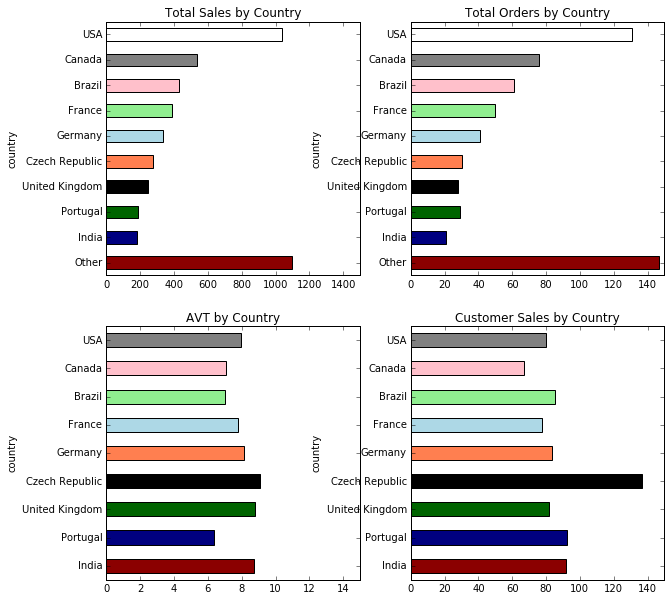

In [58]:
country_summary = run_query(country_summary_q)

colors = ['darkred',
          'navy',
          'darkgreen',
          'black',
          'coral',
          'lightblue',
          'lightgreen',
          'pink',
         'grey',
         'white']


country_summary2 = country_summary[country_summary['country']!='Other']
country_summary = country_summary.iloc[::-1]
country_summary2 = country_summary2.iloc[::-1]
country_summary.set_index('country',inplace=True,drop=True)
country_summary2.set_index('country',inplace=True,drop=True)
fig,axes = plt.subplots(2,2,figsize=(10,10))

country_summary['total_sales'].plot(
    kind = 'barh',
    ax=axes[0][0],
    title = "Total Sales by Country",
    xlim = (0,1500),
    color = colors
    )
plt.gca().invert_yaxis()

country_summary['order_count'].plot(
    kind = 'barh',
    ax=axes[0][1],
    title = "Total Orders by Country",
    xlim = (0,150),
    color = colors
    
    )
plt.gca().invert_yaxis()

country_summary2['average_order'].plot(kind='barh',
    ax = axes[1][0],
    title = "AVT by Country",
    xlim = (0,15),
    color = colors
    
    )


country_summary2['sales_per_customer'].plot(
    kind='barh',
    ax = axes[1][1],
    title = "Customer Sales by Country",
    xlim = (0,150),
    color = colors
    
    )
